<a href="https://colab.research.google.com/github/kukundalynn/Artificial-intelligence/blob/main/Lynn_Recess_Final_%5Bfingerprint_dataset_DL%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
import glob
import re
import cv2 as cv
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet50, inception_v3, densenet
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, layers
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

2023-08-09 12:54:46.430417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 12:54:47.844223: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alvin/anaconda3/envs/asr/lib/python3.9/site-packages/cv2/../../lib64:
2023-08-09 12:54:47.844327: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alvin/anaconda3/envs/asr/lib/python3.9/site-pack

# Custom Metrics

## F1 Score

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

# Instantiate precision and recall metric objects
p = Precision(thresholds=0)
r = Recall(thresholds=0)

def f1_score(y_true, y_pred):
  """
  Function that calculates and returns
  f1_score using Precision and Recall
  """

  def precision(y_true, y_pred):
    """
    Function that calculates and returns precision
    """
    p.update_state(y_true, y_pred)
    return p.result()

  def recall(y_true, y_pred):
    """
    Function that calculates and returns recall
    """
    r.update_state(y_true, y_pred)
    return r.result()

  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)

  result = tf.math.multiply_no_nan(
      tf.constant(2, tf.float32),
      tf.math.divide_no_nan(
          tf.math.multiply_no_nan(
              precision,
              recall
          ),
          tf.math.add(
              precision,
              recall
          )
      )
  )

  return result

# Augmentations

In [ ]:
def random_rotation(img):
  img_shape = img.shape
  img = tf.squeeze(img)

  img = img.numpy().astype(np.uint8)
  img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

  degree = np.random.randint(-15,15,1)[0]

  rows,cols = img.shape
  rotation_matrix = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0), degree, 1)
  img = cv.warpAffine(img, rotation_matrix, (cols,rows))

  img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
  img = tf.convert_to_tensor(img, dtype=tf.float32)

  img = tf.expand_dims(img, 0)
  img.set_shape(img_shape)

  return img

In [ ]:
def hist_eq(img):
  img_shape = img.shape
  img = tf.squeeze(img)

  img = img.numpy().astype(np.uint8)
  img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

  contrast = np.random.uniform(1.0,2.0)
  clahe = cv.createCLAHE(clipLimit=contrast, tileGridSize=(16,16))
  img = clahe.apply(img)

  img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
  img = tf.convert_to_tensor(img, dtype=tf.float32)

  img = tf.expand_dims(img, 0)
  img.set_shape(img_shape)

  return img

In [ ]:
def smoothing(img):
  img_shape = img.shape
  img = tf.squeeze(img)

  img = img.numpy().astype(np.uint8)

  img = cv.GaussianBlur(img,(3,3),0)

  img = tf.convert_to_tensor(img, dtype=tf.float32)

  img = tf.expand_dims(img, 0)
  img.set_shape(img_shape)

  return img

In [ ]:
@tf.function
def augmentation(img):
  img = tf.py_function(hist_eq, [img], tf.float32)
  img = tf.py_function(random_rotation, [img], tf.float32)

  img = tf.reshape(img, (1,96,103,channels))

  return img

# Global Variables

In [ ]:
#Define global variables
channels = 3
image_size = (96,103)
image_shape = image_size + (channels,)
batch_size = 64

rng = tf.random.Generator.from_seed(42, alg='philox')

# Data prep

In [ ]:
dir = '/home/alvin/Documents/recess/fingerprint_datasets'
classes = ['Altered-Easy', 'Altered-Hard', 'Altered-Medium', 'Real']
classes_map = dict(zip(classes,range(len(classes))))
class_dict = {key:len(glob.glob(f'{dir}/{key}/*.BMP')) for key in classes}

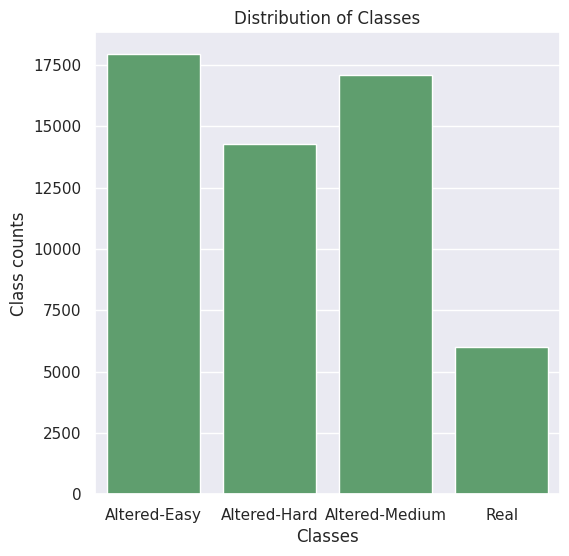

In [ ]:
# Plot class distribution

plt.figure(figsize=(6,6))
sns.barplot(y=list(class_dict.values()), x=list(class_dict.keys()), color='g')
plt.title('Distribution of Classes')
plt.ylabel('Class counts')
plt.xlabel('Classes')
plt.show()

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(dir,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=42,
                                                       image_size=image_size,
                                                       batch_size=batch_size,
                                                       label_mode='categorical',
                                                       labels='inferred'
                                                       )

val_ds = tf.keras.utils.image_dataset_from_directory(dir,
                                                     validation_split=0.2,
                                                     subset="validation",
                                                     seed=42,
                                                     image_size=image_size,
                                                     batch_size=batch_size,
                                                     label_mode='categorical',
                                                     labels='inferred'
                                                     )

Found 55270 files belonging to 4 classes.
Using 44216 files for training.
Found 55270 files belonging to 4 classes.
Using 11054 files for validation.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

['Altered-Easy', 'Altered-Hard', 'Altered-Medium', 'Real']
4


In [ ]:
def get_class_weights():
  total = sum(class_dict.values())
  class_weights = {}

  for class_name, class_count in class_dict.items():
    class_weights[class_names.index(class_name)] = (1 / class_count) * (total / num_classes)

  return class_weights

In [ ]:
class_weights = get_class_weights()
class_weights

{0: 0.7705928280631309,
 1: 0.9681544282511211,
 2: 0.8096033280599988,
 3: 2.3029166666666665}

In [ ]:
def visualize(original, augmented):

  def show(ax, image, title):
    ax.set_title(title)
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  fig = plt.figure(figsize=(9, 9))

  axs = fig.subplots(1, 2)

  show(axs[0], original, 'original')
  show(axs[1], augmented, 'augmented')

In [ ]:
sample = list(train_ds.take(1))[0][0][:1]
sample_aug = augmentation(sample)

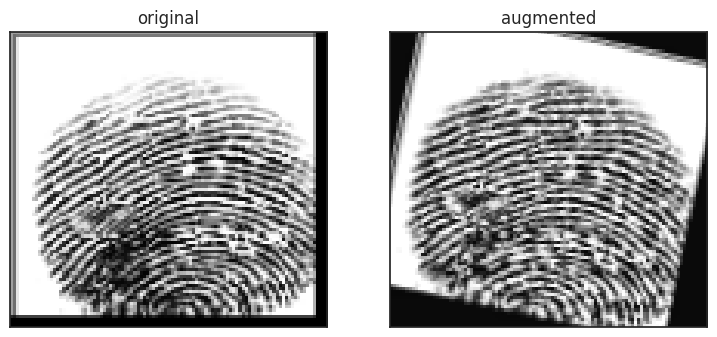

In [ ]:
sample = sample[0].numpy().astype(np.uint8)
sample_aug = sample_aug[0].numpy().astype(np.uint8)

visualize(sample, sample_aug)

In [ ]:
train_ds_aug = train_ds.rebatch(1).map(lambda x, y: (augmentation(x), y)).rebatch(batch_size)
train_ds = train_ds.concatenate(train_ds_aug).rebatch(1).shuffle(buffer_size=2048).rebatch(batch_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 96, 103, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))

# Model

In [ ]:
# Insantiate early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_auc',
                                        patience=10,
                                        mode='max',
                                        start_from_epoch=10,
                                        restore_best_weights=True
                                        )

In [ ]:
# Instantiate pretrained model
pretrained_model = densenet.DenseNet121(
    input_shape=(image_shape), include_top=False, weights='imagenet',
    )

# Freeze the weights of all the layers of the model up until the last Convolution layer
# Leave the bottom few layers trainable so as to fine-tune/update their weights during training
trainable = False
for layer in pretrained_model.layers:
  # if layer.name == "conv5_block16_1_relu":
  #   trainable = True
  layer.trainable = trainable

# Add pooling, dropout and dense layers
pooling = layers.GlobalAveragePooling2D()(pretrained_model.output)
dense = layers.Dense(1024, activation='relu')(pooling)
dropout = layers.Dropout(0.2)(dense)
output = layers.Dense(num_classes)(dropout)

# Create model
model = Model(pretrained_model.input, output)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[f1_score, tf.keras.metrics.AUC(name='auc', from_logits=True)],
              weighted_metrics=[tf.keras.metrics.AUC(name='pr', curve='PR', from_logits=True)]
              )

# Train model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=300,
                    callbacks=[early_stopping_callback],
                    class_weight=class_weights,
                    )

Epoch 1/300
1382/1382 [==============================] - 130s 90ms/step - loss: 1.2500 - f1_score: 0.4011 - auc: 0.6854 - pr: 0.4203 - val_loss: 1.1050 - val_f1_score: 0.4392 - val_auc: 0.7623 - val_pr: 0.4704
Epoch 2/300
1382/1382 [==============================] - 49s 35ms/step - loss: 1.0404 - f1_score: 0.4674 - auc: 0.7572 - pr: 0.5044 - val_loss: 1.0540 - val_f1_score: 0.4812 - val_auc: 0.7836 - val_pr: 0.4974
Epoch 3/300
1382/1382 [==============================] - 49s 36ms/step - loss: 0.9714 - f1_score: 0.4949 - auc: 0.7779 - pr: 0.5291 - val_loss: 1.0318 - val_f1_score: 0.5029 - val_auc: 0.7917 - val_pr: 0.5092
Epoch 4/300
1382/1382 [==============================] - 49s 36ms/step - loss: 0.9322 - f1_score: 0.5114 - auc: 0.7884 - pr: 0.5405 - val_loss: 1.0152 - val_f1_score: 0.5167 - val_auc: 0.7976 - val_pr: 0.5167
Epoch 5/300
1382/1382 [==============================] - 49s 35ms/step - loss: 0.9038 - f1_score: 0.5229 - auc: 0.7963 - pr: 0.5508 - val_loss: 0.9939 - val_f1_sco

In [ ]:
# model.save('/home/alvin/Documents/recess/models/DenseNet121')

# Evaluation

In [ ]:
model = tf.keras.models.load_model('/home/alvin/Documents/recess/models/DenseNet121', custom_objects={'f1_score':f1_score})

In [ ]:
loss =  model.history.history['loss']
val_loss = model.history.history['val_loss']
f1_score = model.history.history['f1_score']
val_f1_score = model.history.history['val_f1_score']
auc_score = model.history.history['auc']
val_auc_score = model.history.history['val_auc']

epochs = range(len(loss))

# Plot training and validation auc
plt.plot(epochs, auc_score, color='blue', label='Training AUC score')
plt.plot(epochs, val_auc_score, color='red', label='Validation AUC score')
plt.xlabel('epochs')
plt.ylabel('score')
plt.title('Training and Validation AUC score')
plt.legend()

plt.figure()

# Plot training and validation f1
plt.plot(epochs, f1_score, color='blue', label='Training F1 score')
plt.plot(epochs, val_f1_score, color='red', label='Validation F1 score')
plt.xlabel('epochs')
plt.ylabel('score')
plt.title('Training and Validation F1 score')
plt.legend()

plt.show()

plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, color='blue', label='Training loss')
plt.plot(epochs, val_loss, color='red', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from imblearn.metrics import classification_report_imbalanced

def cm(y_true, y_pred, labels=None):
  '''
  Generates and displays a confusion matrix
  '''
  matrix = confusion_matrix(y_true, y_pred)

  cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)

  plt.figure(figsize=(8,8))
  plt.title(f"Confusion Matrix")
  cm_display.plot(ax=plt.subplot(), colorbar=False)
  plt.show()

In [ ]:
model.evaluate(val_ds)

173/173 [==============================] - 59s 271ms/step - loss: 0.7778 - f1_score: 0.6392 - auc: 0.8596 - pr: 0.5899


[0.7778156995773315, 0.639198362827301, 0.8595528602600098, 0.5899391174316406]

In [ ]:
# Run inference
y_pred = model.predict(val_ds)
y_pred.shape

173/173 [==============================] - 40s 222ms/step


(11054, 4)

In [ ]:
y_pred

array([[  2.2065716 ,  -8.431977  ,  -5.4627423 ,   7.172323  ],
       [ -6.1393843 ,   3.866909  ,   4.2680197 ,  -9.282249  ],
       [ -2.4095316 ,  -2.2313511 ,  -2.843139  ,   0.6155962 ],
       ...,
       [ -0.38511765,   7.5357056 ,   6.6497316 , -17.385736  ],
       [ -5.35645   ,   4.4921956 ,   2.6270278 ,  -9.401283  ],
       [ -1.9942719 ,  -1.2084559 ,   1.3826469 ,  -3.7433262 ]],
      dtype=float32)

In [ ]:
def unbatch_validation_images():
  '''
  Gets validation images from batches
  '''
  n_val_examples = y_pred.shape[0]

  #Unbatch validation dataset
  val = val_ds.unbatch()
  val = val.batch(batch_size=n_val_examples)

  val_images = []
  val_labels = []

  #Get validation images and labels
  for image, label in val.take(1):
    val_images = image.numpy()
    val_labels = label.numpy()

  return val_images, val_labels

In [ ]:
#Get validation images
val_images, val_labels = unbatch_validation_images()
val_labels.shape

2023-08-09 13:01:43.621343: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1311623424 exceeds 10% of free system memory.


(11054, 4)

In [ ]:
pred_prob = tf.nn.softmax(y_pred).numpy()
pred = pd.get_dummies(np.argmax(pred_prob, axis=-1)).to_numpy().astype(np.float32)
pred.shape

(11054, 4)

In [ ]:
pred_prob

array([[6.9244024e-03, 1.6600426e-07, 3.2332684e-06, 9.9307221e-01],
       [1.8092873e-05, 4.0103796e-01, 5.9894317e-01, 7.8086964e-07],
       [4.2662393e-02, 5.0983321e-02, 2.7652351e-02, 8.7870193e-01],
       ...,
       [2.5703237e-04, 7.0787662e-01, 2.9186633e-01, 1.0634397e-11],
       [4.5733450e-05, 8.6585790e-01, 1.3409559e-01, 8.0091354e-07],
       [3.0629233e-02, 6.7206562e-02, 8.9683664e-01, 5.3275982e-03]],
      dtype=float32)

In [ ]:
pred

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [ ]:
eval_df = pd.DataFrame(data={'target': np.argmax(val_labels, axis=-1),
                             'prediction': np.argmax(y_pred, axis=-1)}
                       ).apply(lambda x: pd.Series(([class_names[x[0]], class_names[x[1]]])), axis=1).rename(columns={0:'target', 1:'prediction'})

correct_df = eval_df.where(eval_df.target == eval_df.prediction).dropna()
incorrect_df = eval_df.where(eval_df.target != eval_df.prediction).dropna()

In [ ]:
# Evaluate results
print(classification_report(val_labels, pred, target_names=class_names))
print(classification_report_imbalanced(np.argmax(val_labels, axis=-1), np.argmax(pred, axis=-1), target_names=class_names))

                precision    recall  f1-score   support

  Altered-Easy       0.75      0.67      0.71      3618
  Altered-Hard       0.65      0.61      0.63      2889
Altered-Medium       0.60      0.56      0.58      3360
          Real       0.52      0.83      0.64      1187

     micro avg       0.64      0.64      0.64     11054
     macro avg       0.63      0.67      0.64     11054
  weighted avg       0.65      0.64      0.64     11054
   samples avg       0.64      0.64      0.64     11054

                      pre       rec       spe        f1       geo       iba       sup

  Altered-Easy       0.75      0.67      0.89      0.71      0.77      0.59      3618
  Altered-Hard       0.65      0.61      0.88      0.63      0.74      0.53      2889
Altered-Medium       0.60      0.56      0.83      0.58      0.68      0.46      3360
          Real       0.52      0.83      0.91      0.64      0.87      0.74      1187

   avg / total       0.65      0.64      0.87      0.64      

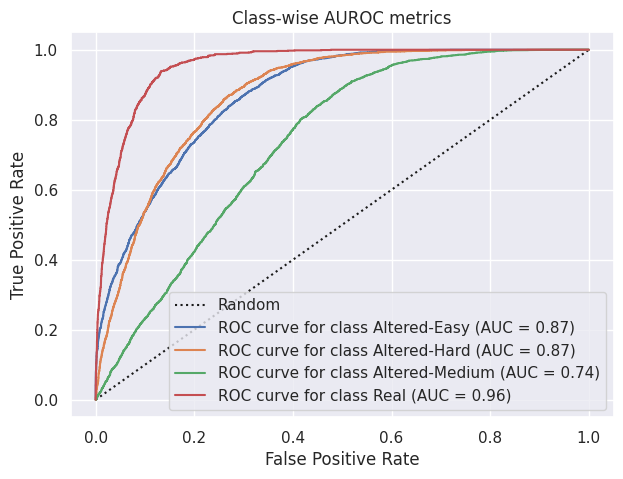

In [ ]:
# Evaluate results
plt.figure(figsize=(7,5))
plt.plot([0,1],[0,1],'k:',label='Random')

for label in range(num_classes):
  fpr,tpr,thresholds = roc_curve(val_labels[:,label], y_pred[:,label])
  roc_auc = roc_auc_score(val_labels[:,label], y_pred[:,label])

  # Plot the results
  plt.plot(fpr, tpr, label='ROC curve for class {0} (AUC = {1:0.2f})'.format(class_names[label], roc_auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid()
  plt.legend()
  plt.title(f'Class-wise AUROC metrics')

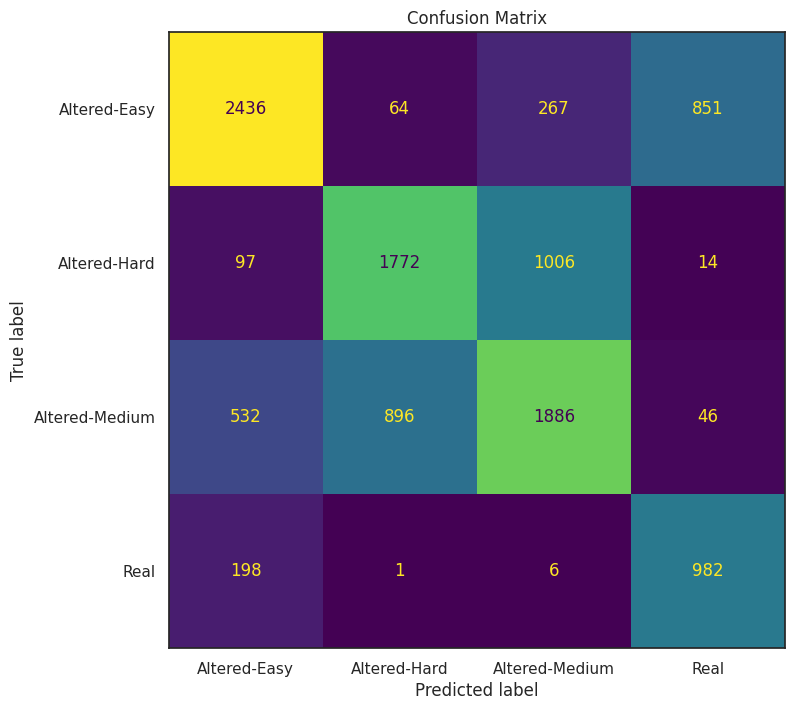

In [ ]:
# Plot confusion matrix
sns.set_theme(style="white", palette=None)
cm(np.argmax(val_labels, axis=-1), np.argmax(pred, axis=-1), labels=class_names)

In [ ]:
import cv2
import random

def get_saliency_map(img_idx):
  # get the image
  image = val_images[img_idx]

  # add a batch dimension in front
  img = np.expand_dims(image, axis=0)
  expected_output = np.expand_dims(val_labels[img_idx], axis=0)

  with tf.GradientTape() as tape:
      # covert to tensor
      inputs = tf.convert_to_tensor(img, dtype=tf.float32)

      # watch the input pixels
      tape.watch(inputs)

      # generate the predictions
      prediction = model(inputs)

      # get the loss
      loss = tf.keras.losses.categorical_crossentropy(
          expected_output, prediction, from_logits=True
      )

  # get the gradient with respect to the inputs
  gradients = tape.gradient(loss, inputs)

  # reduce the RGB image to grayscale
  grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

  # normalize the pixel values to be in the range [0, 255].
  # the max value in the grayscale tensor will be pushed to 255.
  # the min value will be pushed to 0.
  normalized_tensor = tf.cast(
      255
      * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
      / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
      tf.uint8,
  )

  # remove the channel dimension to make the tensor a 2d tensor
  normalized_tensor = tf.squeeze(normalized_tensor)

  gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
  gradient_color = gradient_color / 255.0
  super_imposed = cv2.addWeighted(image, 0.5, gradient_color.astype(np.float32), 0.5, 0.0)

  ax = plt.subplot(2, 4, i+1)
  plt.title(f"Confidence: {np.round(np.max(tf.nn.softmax(prediction).numpy(), axis=-1), 4)}")
  plt.imshow(super_imposed)
  plt.axis('off')

In [ ]:
# get model
model = tf.keras.models.load_model('/home/alvin/Documents/recess/models/DenseNet121', custom_objects={'f1_score':f1_score})

In [ ]:
idxs = random.choices(correct_df.where(correct_df.target == 'Real').dropna().index.tolist(), k=8)

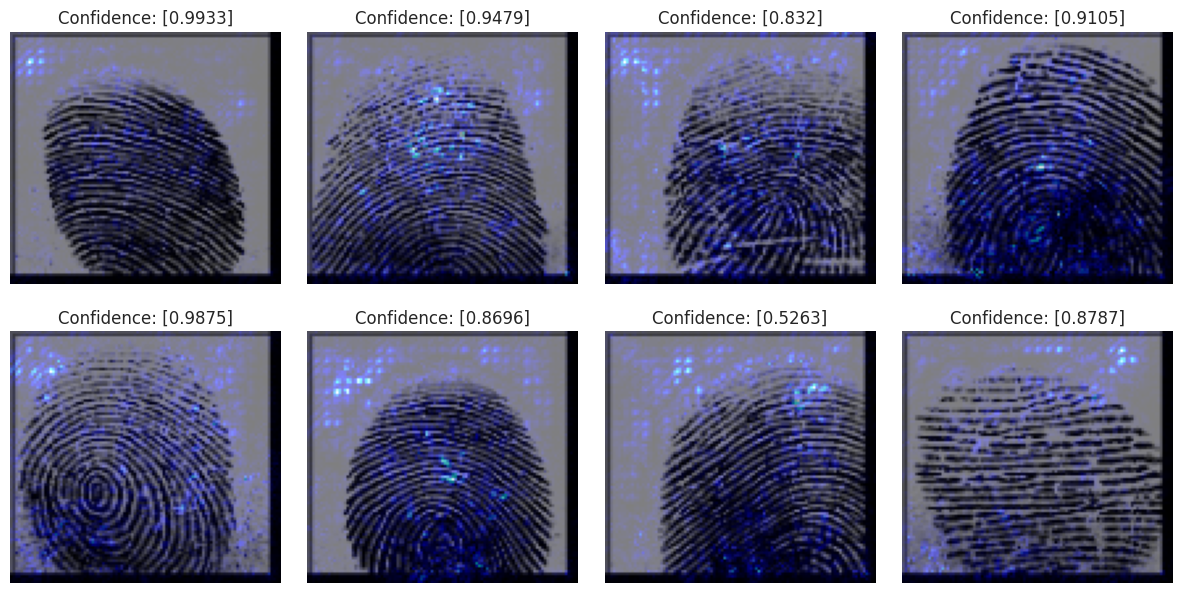

In [ ]:
plt.figure(figsize=(15, 15))

for i in range(len(idxs)):
  get_saliency_map(img_idx=idxs[i])

plt.subplots_adjust(hspace=-0.65)
plt.subplots_adjust(wspace=0.1)

In [ ]:
idxs = random.choices(correct_df.where(correct_df.target == 'Altered-Easy').dropna().index.tolist(), k=8)

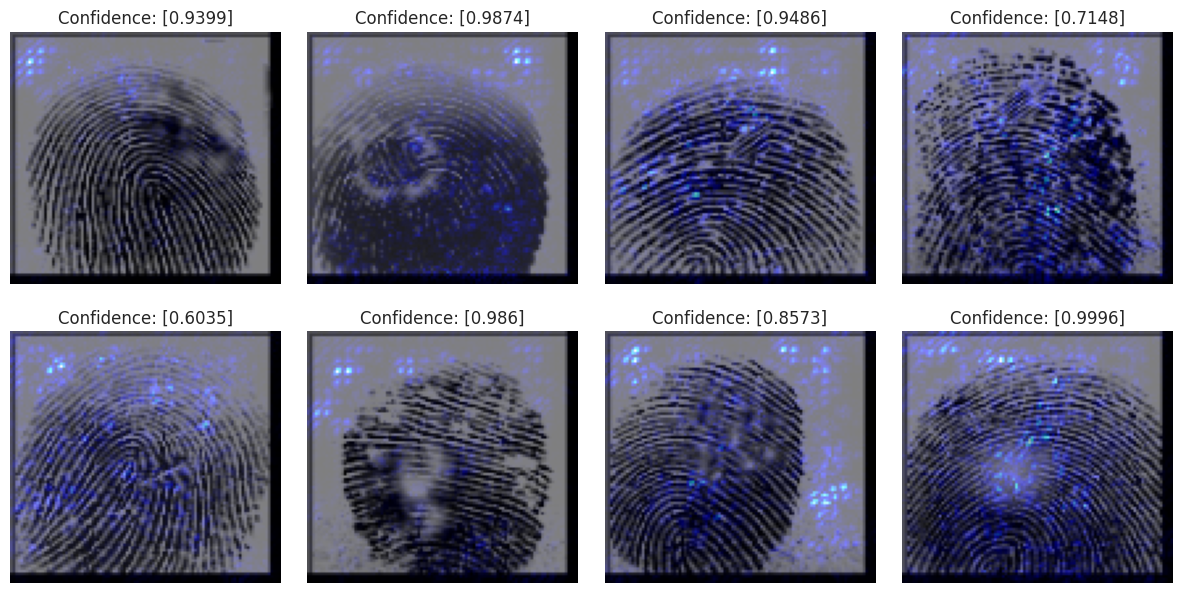

In [ ]:
plt.figure(figsize=(15, 15))

for i in range(len(idxs)):
  get_saliency_map(img_idx=idxs[i])

plt.subplots_adjust(hspace=-0.65)
plt.subplots_adjust(wspace=0.1)

In [ ]:
idxs = random.choices(correct_df.where(correct_df.target == 'Altered-Medium').dropna().index.tolist(), k=8)

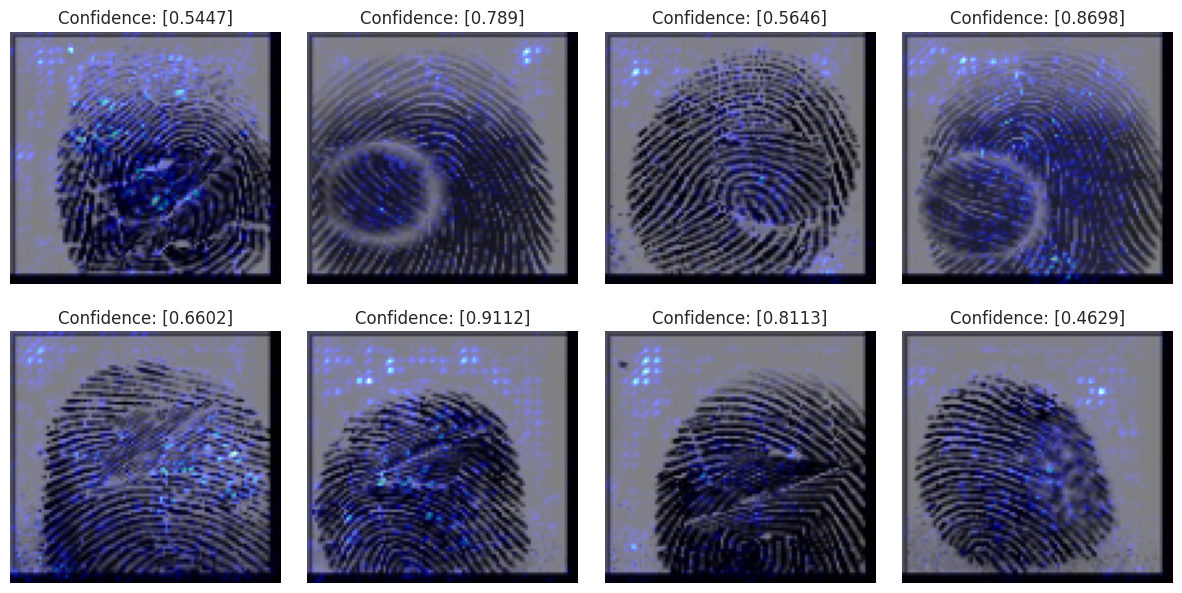

In [ ]:
plt.figure(figsize=(15, 15))

for i in range(len(idxs)):
  get_saliency_map(img_idx=idxs[i])

plt.subplots_adjust(hspace=-0.65)
plt.subplots_adjust(wspace=0.1)

In [ ]:
idxs = random.choices(correct_df.where(correct_df.target == 'Altered-Hard').dropna().index.tolist(), k=8)

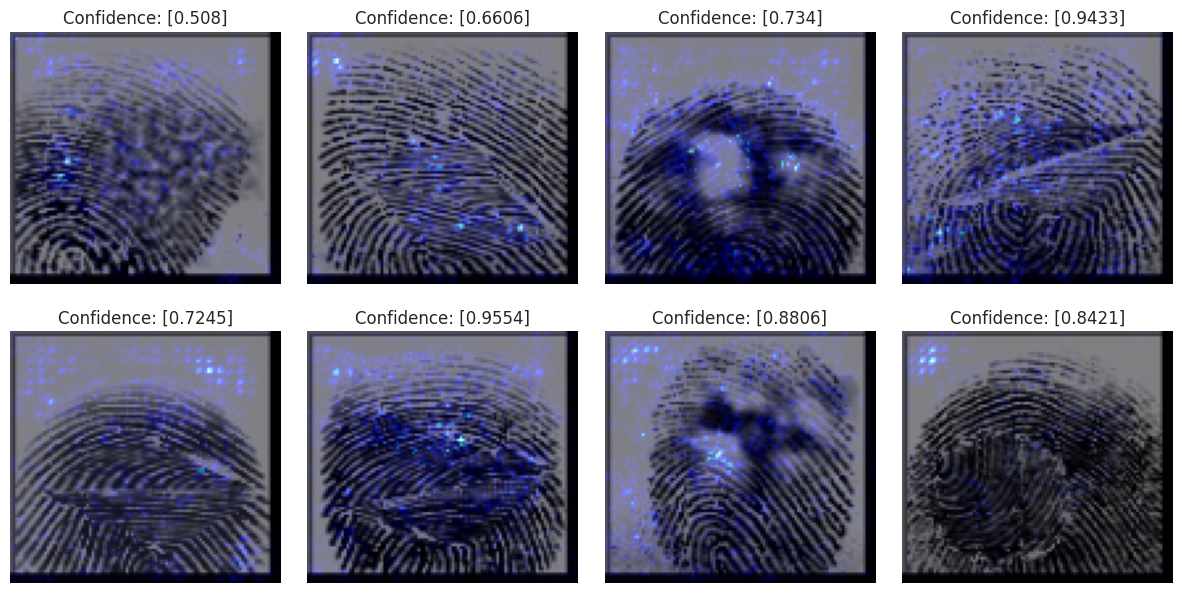

In [ ]:
plt.figure(figsize=(15, 15))

for i in range(len(idxs)):
  get_saliency_map(img_idx=idxs[i])

plt.subplots_adjust(hspace=-0.65)
plt.subplots_adjust(wspace=0.1)